## Capstone Project : Credit Card Fraud Detection
### Submitted By : Ashim Kishore Goswami and Nitin Mishra
In this project we will predict fraudulent credit card transactions with the help of Machine learning models.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN 
from collections import Counter
from scipy import interp
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Exploratory data analysis

In [2]:
# Importing dataset
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Here we will observe the distribution of our classes

In [5]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100
print('No. of Fraudulant Transactions = ',classes[1],'\nNo. of Non - Fraudulant Transactions = ',classes[0])
print('Percentage of Fraudulant Transactions = ',round(100*classes[1]/len(df),3))

No. of Fraudulant Transactions =  492 
No. of Non - Fraudulant Transactions =  284315
Percentage of Fraudulant Transactions =  0.173


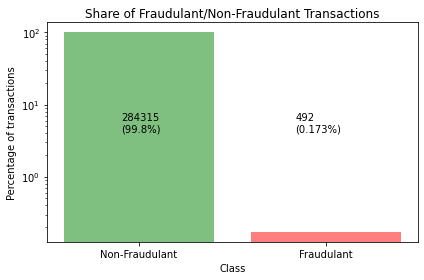

In [6]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
objects = ('Non-Fraudulant', 'Fraudulant')
y_pos = np.arange(len(objects))
plt.bar(y_pos, [normal_share, fraud_share], align='center', color=['g','r'], alpha=0.5)
plt.xticks(y_pos, objects)
plt.yscale('log')     # Using log scale for better visualisation
plt.xlabel('Class')
plt.ylabel('Percentage of transactions')
plt.annotate('{}\n({:.3}%)'.format(classes[0], normal_share), (0.20, 0.5), xycoords='axes fraction')
plt.annotate('{}\n({:.3}%)'.format(classes[1], fraud_share),  (0.67, 0.5), xycoords='axes fraction')
plt.title('Share of Fraudulant/Non-Fraudulant Transactions')
plt.tight_layout()

plt.show()

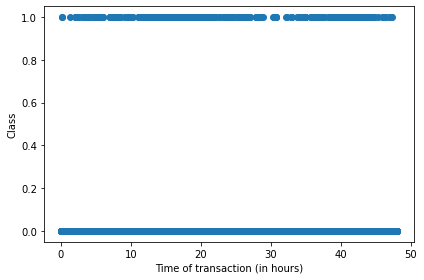

In [7]:
# Create a scatter plot to observe the distribution of classes with time
plt.scatter(df['Time']/(60*60), df['Class'])
plt.xlabel('Time of transaction (in hours)')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

#### Here we can see that Time variable is not a good indicator of fraudulant transactions.

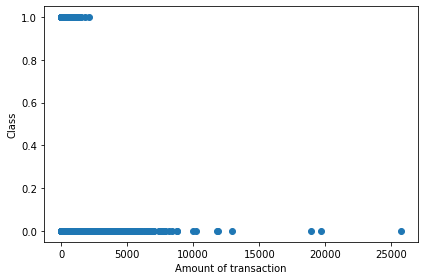

In [8]:
# Create a scatter plot to observe the distribution of classes with Amount
plt.scatter(df['Amount'], df['Class'])
plt.xlabel('Amount of transaction')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

#### This shows that Most of the fraudulant transactions are of low value(i.e. less than $5000)

Number of outliers below the lower bound:  0  (0.0%)
Number of outliers above the upper bound:  31904  (11.2%)


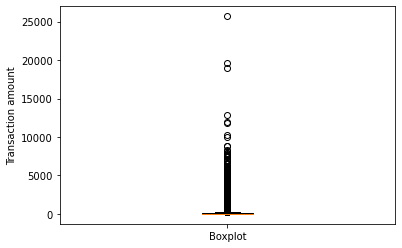

In [9]:
# Checking for outliers in Amount

plt.boxplot(df['Amount'], labels = ['Boxplot'])
plt.ylabel('Transaction amount')
plt.plot()

amount = df[['Amount']].sort_values(by='Amount')
q1, q3 = np.percentile(amount,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

print('Number of outliers below the lower bound: ', amount[amount['Amount'] < lower_bound].count()[0],
     ' ({:.4}%)'.format(amount[amount['Amount'] < lower_bound].count()[0] / amount['Amount'].count() * 100))
print('Number of outliers above the upper bound: ', amount[amount['Amount'] > upper_bound].count()[0],
      ' ({:.4}%)'.format(amount[amount['Amount'] > upper_bound].count()[0] / amount['Amount'].count() * 100))

Using IQR method (Interquartile range) we found 31,904 outliers, which is 11.2% of whole dataset.
We are not removing this 11.2% as it would be a bad idea because of data loss.

In [10]:
# No. of fraudulant transactions present in outliers
df[df['Class']==1].where(df['Amount']>upper_bound).count()['Amount']

91

In [11]:
# Checking description of dataset values
df.describe(percentiles=[0.01,0.05,0.25,0.50,0.75,0.95,0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,2422.000000,25297.600000,54201.500000,84692.000000,139320.500000,164143.400000,170560.940000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-6.563199,-2.899147,-0.920373,0.018109,1.315642,2.081223,2.237130,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-4.960300,-1.971975,-0.598550,0.065486,0.803724,1.808585,3.801811,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-3.978377,-2.389740,-0.890365,0.179846,1.027196,2.062635,2.728434,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-3.122987,-2.195683,-0.848640,-0.019847,0.743341,2.566501,4.248032,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-3.060396,-1.702021,-0.691597,-0.054336,0.611926,2.098960,3.424903,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-2.124023,-1.406757,-0.768296,-0.274187,0.398565,3.160382,4.200085,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-3.012847,-1.434423,-0.554076,0.040103,0.570436,1.407632,2.696205,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-4.033899,-0.842147,-0.208630,0.022358,0.327346,1.049984,2.075973,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-2.455288,-1.758426,-0.643098,-0.051429,0.597139,1.780783,2.986773,15.594995


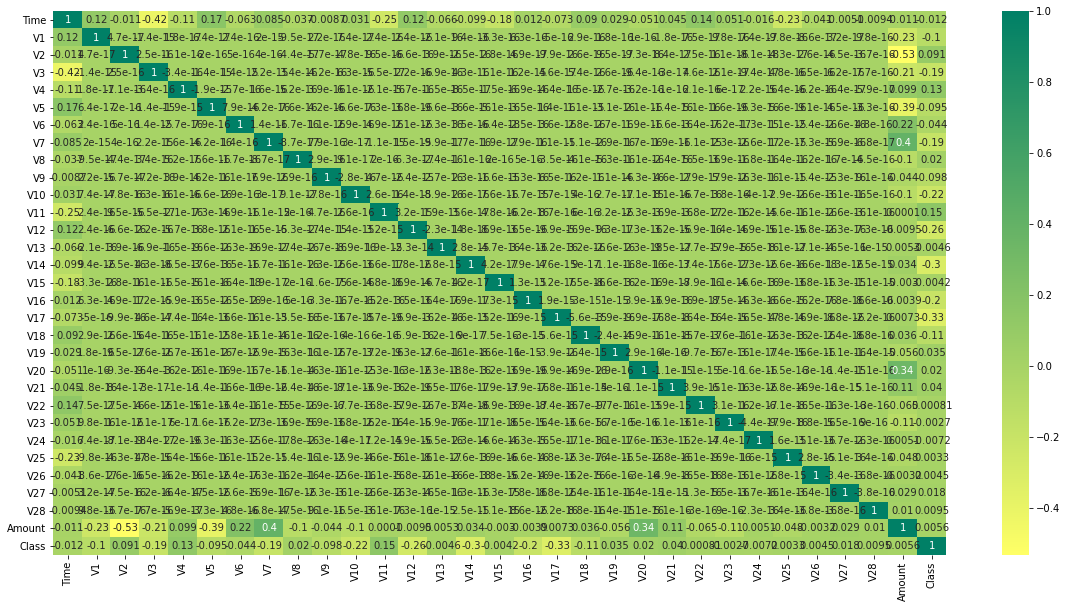

In [12]:
# Correlation Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, cmap='summer_r')
plt.show()

Droping the column 'Time' as it's distribution with class variable doesn't give any insight. Also it was guided in the doubt solving session on case study the mentor had told that the time column might not be so useful.

In [3]:
df = df.drop(columns = ['Time'])
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Putting target variable into y and others in X
y = df['Class']                  #class variable
X = df.drop(columns=['Class'])

### Plotting the distribution of a variable to see if there is any skewness present in the dataset

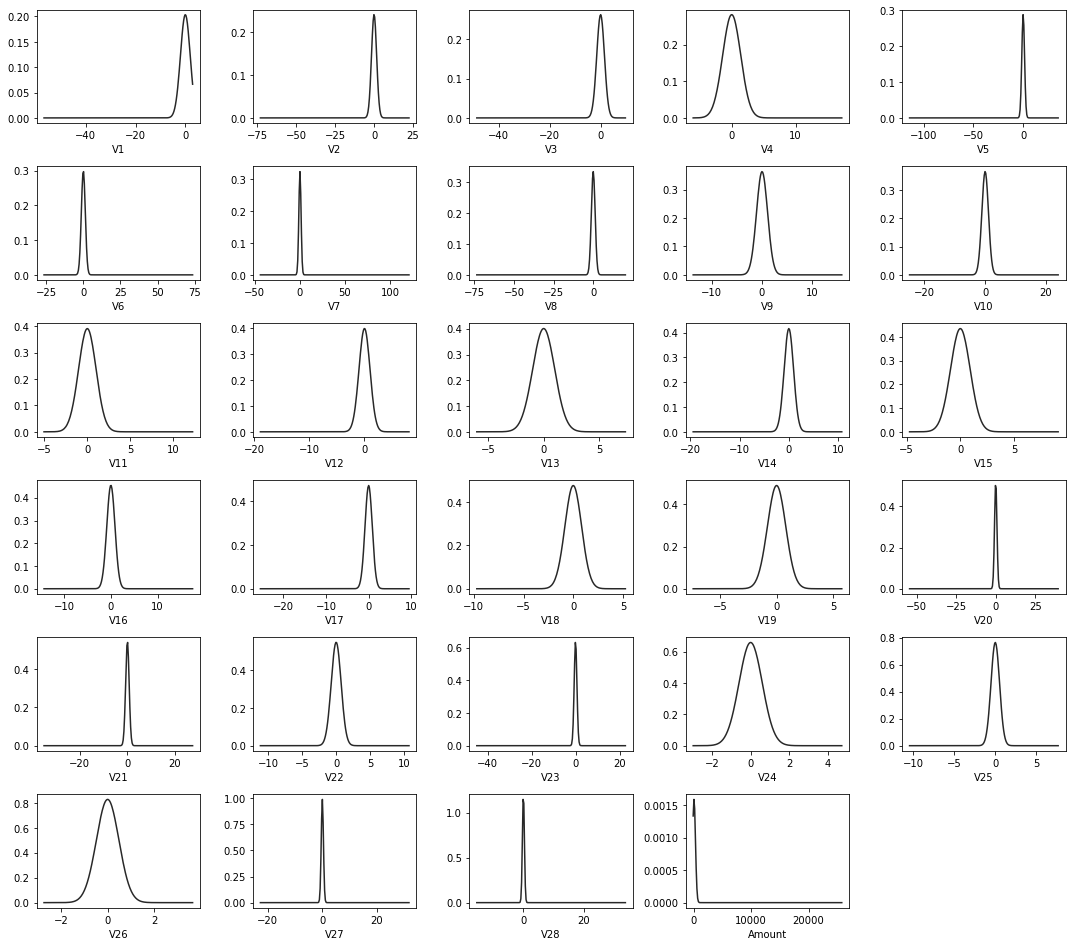

In [5]:
num_col = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
           'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
           'V21','V22','V23','V24','V25','V26','V27','V28','Amount']

#Function to plot the distribution plot of the numeric variable list
from scipy.stats import norm
def distplots(var_list, df):
    plt.figure(figsize=(15,15))
    for var in var_list:
        plt.subplot(7,5,var_list.index(var)+1)
        sns.distplot(df[var], fit=norm, kde=False, hist=False)
        #sns.boxplot(y=var,palette='cubehelix', data=main_df)
    # Automatically adjust subplot params so that the subplotS fits in to the figure area.
    plt.tight_layout()
    # display the plot
    plt.show()
    
distplots(num_col, X)  

### Treating skewness by powertransform

In [6]:
cols = X.columns
cols

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [7]:
# Applying preprocessing.PowerTransformer(copy=False) to fit & transform data
from sklearn import preprocessing
X_temp = pd.DataFrame(preprocessing.PowerTransformer(standardize=True, copy=False).fit_transform(X), columns = cols)

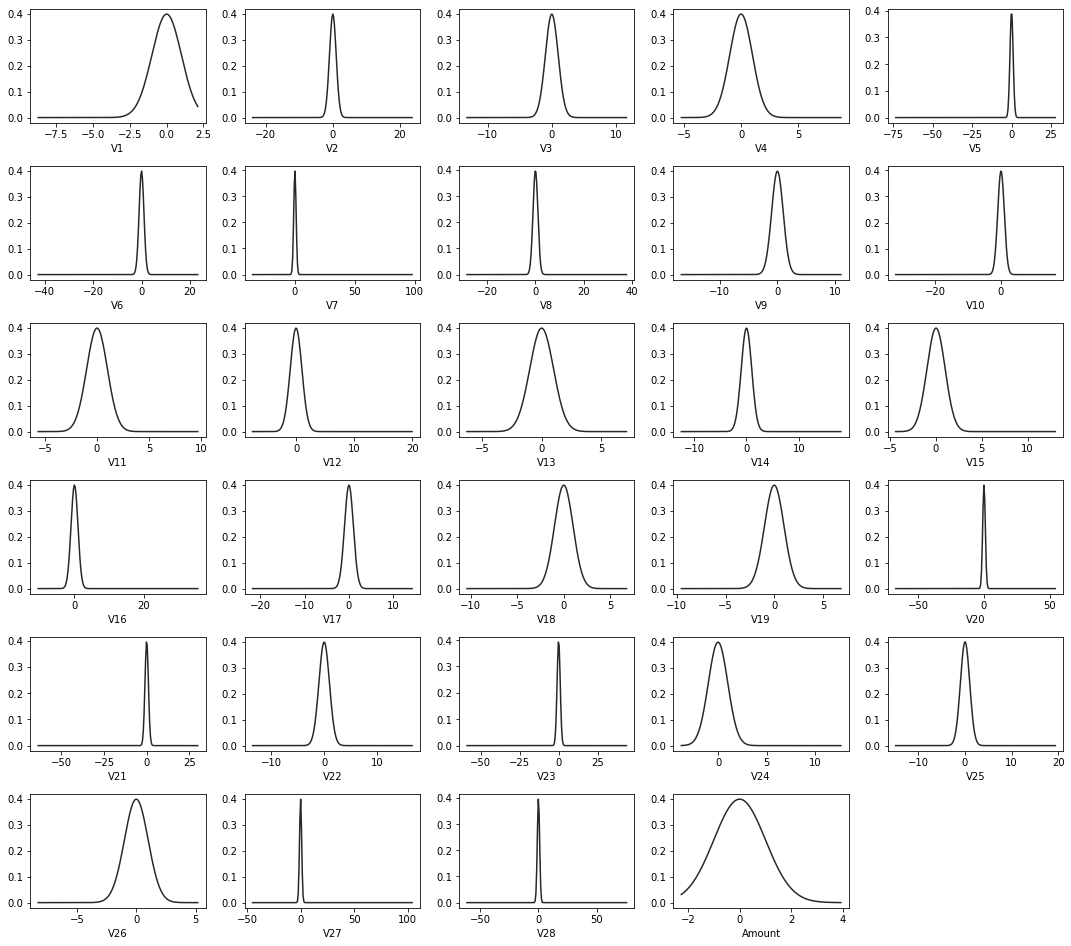

In [8]:
# Plotting distplots to see if skewness has been treated
distplots(num_col, X_temp)

Here we can see that skewness of all the variables have been treated

In [9]:
X = X_temp
X.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,284807.0,-1.099838e-16,1.000002,-8.474209,-0.722984,-0.248960,0.735777,1.868337
V2,284807.0,8.821690e-17,1.000002,-23.714185,-0.453539,-0.041674,0.475440,23.425505
V3,284807.0,1.749637e-15,1.000002,-13.017494,-0.712354,-0.025126,0.673837,11.432547
V4,284807.0,1.486271e-16,1.000002,-5.019738,-0.569404,0.063182,0.582842,8.543672
V5,284807.0,-3.167158e-15,1.000002,-73.293859,-0.509261,-0.051083,0.436246,27.502326
V6,284807.0,3.450783e-16,1.000002,-42.559395,-0.556779,-0.114006,0.413431,23.060578
V7,284807.0,1.185477e-16,1.000002,-35.152211,-0.448000,0.032243,0.460997,97.689206
V8,284807.0,2.307642e-16,1.000002,-28.074503,-0.274985,-0.055378,0.255875,37.403416
V9,284807.0,8.599507e-16,1.000002,-16.370213,-0.560900,0.006934,0.582538,10.730491
V10,284807.0,-1.223316e-16,1.000002,-31.852785,-0.474036,-0.044775,0.455951,16.284968


### Splitting the data into train & test data

In [10]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state=5)       

### Standardising Features

In [11]:
# standardising X_train and X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

##### Checking the No. of fraudulant transactions in train and test dataset

In [22]:
print("No. of Fraudulant Transactions in original data = ",np.sum(y))
print("No. of Fraudulant Transactions in training data = ",np.sum(y_train))
print("No. of Fraudulant Transactions in test data = ",np.sum(y_test))

No. of Fraudulant Transactions in original data =  492
No. of Fraudulant Transactions in training data =  344
No. of Fraudulant Transactions in test data =  148


## Model Building
- Building 7 different models on the imbalanced, SMOTE and ADASYN oversampling datasets

In [23]:
# Dictionary of model names and models
models = {'Logistic Regression': LogisticRegression(random_state = 42),
          'K-NN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state = 42),
          'Random Forest': RandomForestClassifier(max_depth=5, random_state = 42),
          'ADA BOOST': AdaBoostClassifier(random_state = 42),
          'Gradient BOOST': GradientBoostingClassifier(random_state = 42),
          'XG BOOST': XGBClassifier()
         }

In [12]:
# Function to draw ROC CURVE
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    print('\nAUC score = {:2.2f}%'.format(auc_score*100))
    return auc_score

In [13]:
# Function for printing scores and returning Accuracy, precision and recall scores
def print_Scores(actual, predictions):
    print("\n\nActual 1's = ",actual.sum(),"\nPredicted 1's = ",predictions.sum())
    confusion_matrix_total = [[0, 0], [0, 0]] 
    #Store the confusion matrix result to plot a table later
    cnf_matrix = confusion_matrix(actual, predictions)
    confusion_matrix_total += cnf_matrix
    print('\n',cnf_matrix)
    #Print precision and recall
    tn, fp = confusion_matrix_total.tolist()[0]
    fn, tp = confusion_matrix_total.tolist()[1]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print('\nAccuracy = {:2.2f}%'.format(accuracy*100))
    print('Precision = {:2.2f}%'.format(precision*100))
    print('Recall = {:2.2f}%'.format(recall*100))
    return accuracy, precision, recall




          **********  Logistic Regression --- TRAIN SCORES  **********


Cross Validation Mean Score:  98.1%


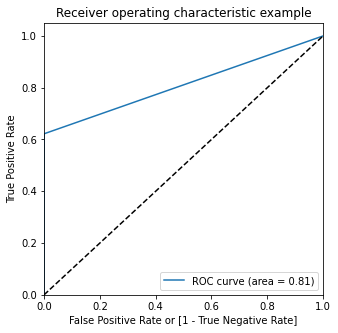


AUC score = 81.10%


Actual 1's =  344 
Predicted 1's =  246

 [[198988     32]
 [   130    214]]

Accuracy = 99.92%
Precision = 86.99%
Recall = 62.21%



          **********  Logistic Regression --- TEST SCORES  **********


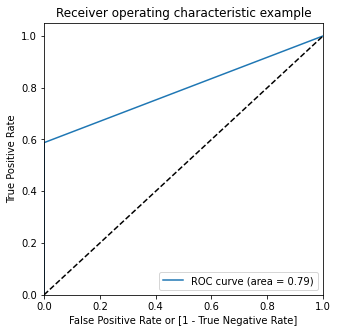


AUC score = 79.39%


Actual 1's =  148 
Predicted 1's =  97

 [[85285    10]
 [   61    87]]

Accuracy = 99.92%
Precision = 89.69%
Recall = 58.78%



          **********  K-NN --- TRAIN SCORES  **********


Cross Validation Mean Score:  91.8%


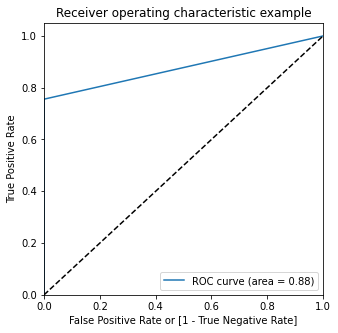


AUC score = 87.78%


Actual 1's =  344 
Predicted 1's =  293

 [[198987     33]
 [    84    260]]

Accuracy = 99.94%
Precision = 88.74%
Recall = 75.58%



          **********  K-NN --- TEST SCORES  **********


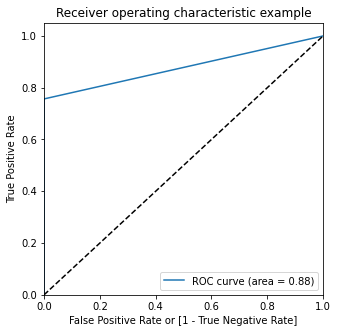


AUC score = 87.83%


Actual 1's =  148 
Predicted 1's =  119

 [[85288     7]
 [   36   112]]

Accuracy = 99.95%
Precision = 94.12%
Recall = 75.68%



          **********  Decision Tree --- TRAIN SCORES  **********


Cross Validation Mean Score:  89.7%


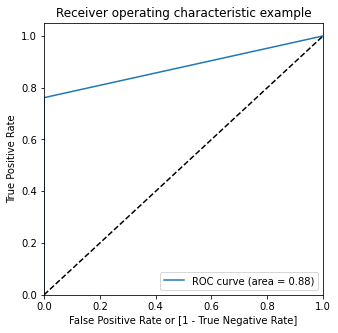


AUC score = 88.07%


Actual 1's =  344 
Predicted 1's =  294

 [[198988     32]
 [    82    262]]

Accuracy = 99.94%
Precision = 89.12%
Recall = 76.16%



          **********  Decision Tree --- TEST SCORES  **********


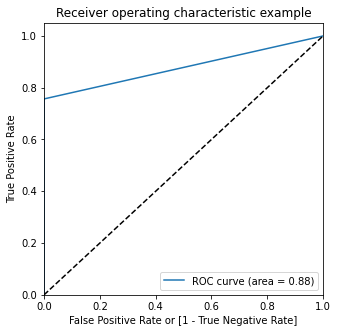


AUC score = 87.83%


Actual 1's =  148 
Predicted 1's =  119

 [[85288     7]
 [   36   112]]

Accuracy = 99.95%
Precision = 94.12%
Recall = 75.68%



          **********  Random Forest --- TRAIN SCORES  **********


Cross Validation Mean Score:  97.2%


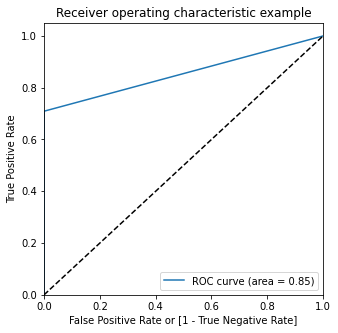


AUC score = 85.46%


Actual 1's =  344 
Predicted 1's =  268

 [[198996     24]
 [   100    244]]

Accuracy = 99.94%
Precision = 91.04%
Recall = 70.93%



          **********  Random Forest --- TEST SCORES  **********


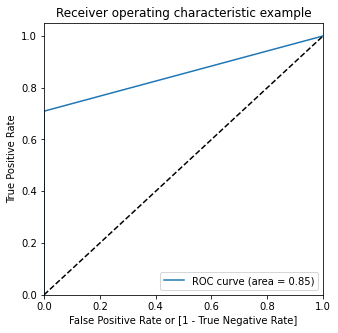


AUC score = 85.47%


Actual 1's =  148 
Predicted 1's =  111

 [[85289     6]
 [   43   105]]

Accuracy = 99.94%
Precision = 94.59%
Recall = 70.95%



          **********  ADA BOOST --- TRAIN SCORES  **********


Cross Validation Mean Score:  97.89999999999999%


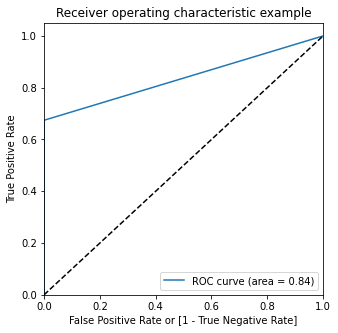


AUC score = 83.71%


Actual 1's =  344 
Predicted 1's =  293

 [[198959     61]
 [   112    232]]

Accuracy = 99.91%
Precision = 79.18%
Recall = 67.44%



          **********  ADA BOOST --- TEST SCORES  **********


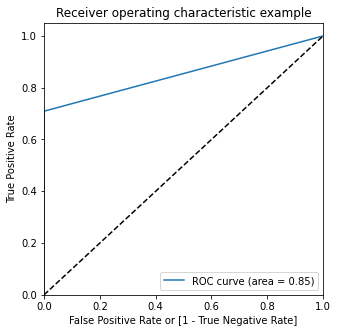


AUC score = 85.46%


Actual 1's =  148 
Predicted 1's =  132

 [[85268    27]
 [   43   105]]

Accuracy = 99.92%
Precision = 79.55%
Recall = 70.95%



          **********  Gradient BOOST --- TRAIN SCORES  **********


Cross Validation Mean Score:  78.9%


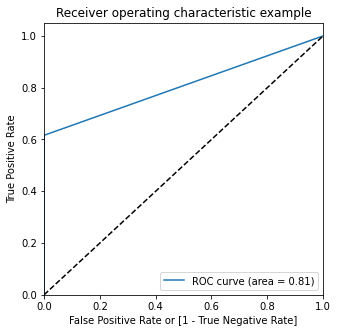


AUC score = 80.80%


Actual 1's =  344 
Predicted 1's =  249

 [[198983     37]
 [   132    212]]

Accuracy = 99.92%
Precision = 85.14%
Recall = 61.63%



          **********  Gradient BOOST --- TEST SCORES  **********


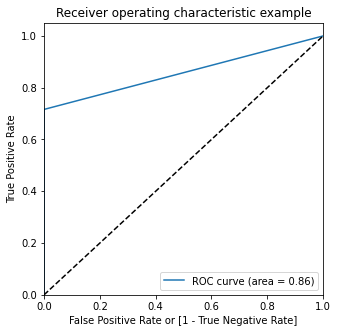


AUC score = 85.80%


Actual 1's =  148 
Predicted 1's =  117

 [[85284    11]
 [   42   106]]

Accuracy = 99.94%
Precision = 90.60%
Recall = 71.62%



          **********  XG BOOST --- TRAIN SCORES  **********


Cross Validation Mean Score:  98.5%


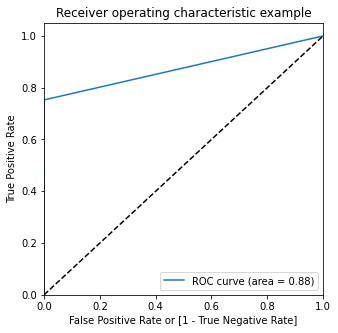


AUC score = 87.64%


Actual 1's =  344 
Predicted 1's =  292

 [[198987     33]
 [    85    259]]

Accuracy = 99.94%
Precision = 88.70%
Recall = 75.29%



          **********  XG BOOST --- TEST SCORES  **********


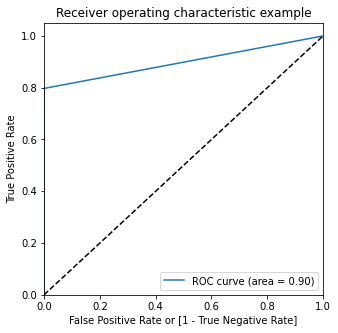


AUC score = 89.86%


Actual 1's =  148 
Predicted 1's =  127

 [[85286     9]
 [   30   118]]

Accuracy = 99.95%
Precision = 92.91%
Recall = 79.73%


In [28]:
# Creating a df to store train and test scores of all 7 models
dashboard_imbalanced = pd.DataFrame(columns = ['Model','Sampling Method', 'Train/Test', 'AUC Score', 'Accuracy', 'Precision', 'Recall'])

# Default Model fitting and testing
for model in models.keys():
    # with imbalanced train data 
    m = models[model].fit(X_train, y_train)
    y_train_pred = cross_val_predict(m, X_train, y_train, cv=5)
    scores = cross_val_score(m, X_train, y_train, scoring='roc_auc', cv=5)
    print("\n\n\n          **********  {} --- TRAIN SCORES  **********".format(model))
    print ("\n\nCross Validation Mean Score: ", '{}%'.format(np.round(scores.mean(), 3) * 100))
    auc = draw_roc(y_train, y_train_pred)
    accuracy, precision, recall = print_Scores(y_train, y_train_pred)
    dashboard_imbalanced = dashboard_imbalanced.append({'Model' : model ,'Sampling Method' : 'None','Train/Test' : 'Train',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True)
    
    # with imbalance test data
    y_pred = m.predict(X_test)
    print("\n\n\n          **********  {} --- TEST SCORES  **********".format(model))
    auc = draw_roc(y_test, y_pred)
    accuracy, precision, recall = print_Scores(y_test, y_pred)
    dashboard_imbalanced = dashboard_imbalanced.append({'Model' : model ,'Sampling Method' : 'None','Train/Test' : 'Test',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True) 

In [29]:
dashboard_imbalanced

,Model,Sampling Method,Train/Test,AUC Score,Accuracy,Precision,Recall
0,Logistic Regression,None,Train,0.810966,0.999187,0.869919,0.622093
1,Logistic Regression,None,Test,0.793860,0.999169,0.896907,0.587838
2,K-NN,None,Train,0.877824,0.999413,0.887372,0.755814
3,K-NN,None,Test,0.878337,0.999497,0.941176,0.756757
4,Decision Tree,None,Train,0.880734,0.999428,0.891156,0.761628
5,Decision Tree,None,Test,0.878337,0.999497,0.941176,0.756757
6,Random Forest,None,Train,0.854591,0.999378,0.910448,0.709302
7,Random Forest,None,Test,0.854695,0.999427,0.945946,0.709459
8,ADA BOOST,None,Train,0.837056,0.999132,0.791809,0.674419
9,ADA BOOST,None,Test,0.854571,0.999181,0.795455,0.709459


In [30]:
# Sorted all the models based on AUC and Recall scores for choosing the best performer.
dashboard_imbalanced = dashboard_imbalanced.sort_values(['AUC Score','Recall'], ascending=[False,False])
dashboard_imbalanced

,Model,Sampling Method,Train/Test,AUC Score,Accuracy,Precision,Recall
13,XG BOOST,None,Test,0.898596,0.999544,0.929134,0.797297
4,Decision Tree,None,Train,0.880734,0.999428,0.891156,0.761628
3,K-NN,None,Test,0.878337,0.999497,0.941176,0.756757
5,Decision Tree,None,Test,0.878337,0.999497,0.941176,0.756757
2,K-NN,None,Train,0.877824,0.999413,0.887372,0.755814
12,XG BOOST,None,Train,0.876371,0.999408,0.886986,0.752907
11,Gradient BOOST,None,Test,0.858044,0.999380,0.905983,0.716216
7,Random Forest,None,Test,0.854695,0.999427,0.945946,0.709459
6,Random Forest,None,Train,0.854591,0.999378,0.910448,0.709302
9,ADA BOOST,None,Test,0.854571,0.999181,0.795455,0.709459


Here if we see XGBOOST gives best AUC on test and best recall also. We will tune XGBOOST for imbalanced data.
## Hyper parameter tuning : Imbalanced data - XGBOOST Classifier

### 1. Tuning learning_rate

In [40]:
n_folds = 5       # No of folds for gridsearch CV
# parameters to build the model on
parameters = {"learning_rate"    : [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2] }
# instantiate the model
xg = XGBClassifier(random_state = 42)
# fit tree on training data
xgb = GridSearchCV(xg, parameters, 
                    cv = n_folds,
                    n_jobs = -1,
                    return_train_score = True,
                    scoring="roc_auc")
xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15,
                                           0.2]},
             pre_dispatch='2*n_jobs', refit=True, 

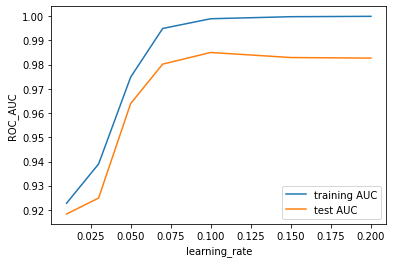

In [42]:
scores = xgb.cv_results_
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_learning_rate"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_learning_rate"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("learning_rate")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

We can see that test score climbs up till learning rate = 0.7 to 1.0

### 2. Tuning max_depth

In [43]:
# parameters to build the model on
parameters = {'max_depth': range(3,7)}
xgb = GridSearchCV(xg, parameters, 
                    cv = n_folds,
                    n_jobs = -1,
                    return_train_score = True,
                    scoring="roc_auc")
xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1, param_grid={'max_depth': range(3, 7)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

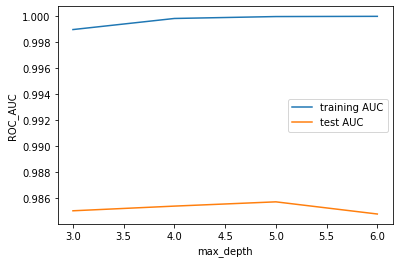

In [44]:
scores = xgb.cv_results_

plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("max_depth")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

This shows that test Score increases upto max_depth = 5.
### 3. Tuning  min_child_weight

In [45]:
# parameters to build the model on
parameters = {"min_child_weight" : [ 1, 3, 5, 7, 9]}
xgb = GridSearchCV(xg, parameters, 
                    cv = n_folds,
                    n_jobs = -1,
                    return_train_score = True,
                    scoring="roc_auc")
xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_weight': [1, 3, 5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=

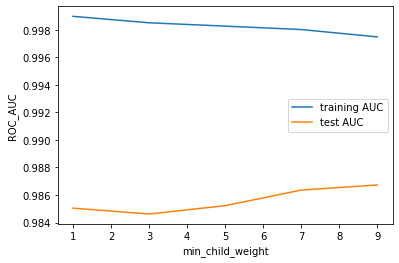

In [46]:
scores = xgb.cv_results_

plt.figure()
plt.plot(scores["param_min_child_weight"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_min_child_weight"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("min_child_weight")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

Here we can test min_child_weight as 7,8,9
### 4. Tuning gamma

In [47]:
# parameters to build the model on
parameters = {"gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]}
xgb = GridSearchCV(xg, parameters, 
                    cv = n_folds,
                    n_jobs = -1,
                    return_train_score = True,
                    scoring="roc_auc")
xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0

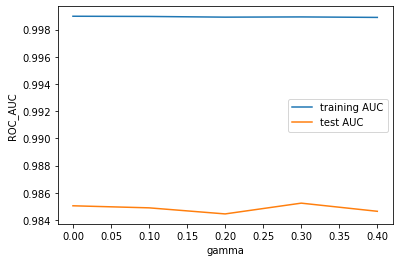

In [48]:
scores = xgb.cv_results_

plt.figure()
plt.plot(scores["param_gamma"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_gamma"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("gamma")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

Suitable value for gamma = 0.30
### 5. Tuning subsample

In [28]:
# parameters to build the model on
parameters = {"subsample" : [ 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
xg = XGBClassifier(random_state = 42)
xgb = GridSearchCV(xg, parameters, 
                    cv = 5,
                    n_jobs = -1,
                    return_train_score = True,
                    scoring="roc_auc")
xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
         

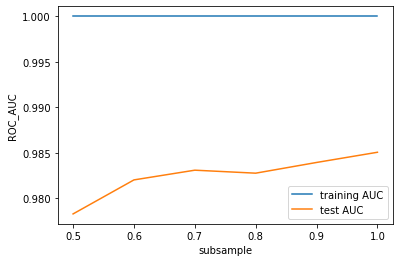

In [29]:
scores = xgb.cv_results_

plt.figure()
plt.plot(scores["param_subsample"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_subsample"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("subsample")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

Subsample must be around 0.6, 0.7, 0.8
### 6. Tuning colsample_bytree

In [30]:
# parameters to build the model on
parameters = {"colsample_bytree" : [ 0.5, 0.6, 0.7, 0.8]}
xgb = GridSearchCV(xg, parameters, 
                    cv = 5,
                    n_jobs = -1,
                    return_train_score = True,
                    scoring="roc_auc")
xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
         

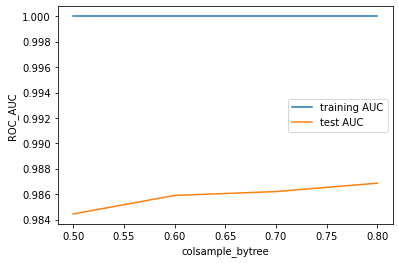

In [33]:
scores = xgb.cv_results_

plt.figure()
plt.plot(scores["param_colsample_bytree"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_colsample_bytree"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("colsample_bytree")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

### Grid Search to Find Optimal Hyperparameters

In [ ]:
# Create the parameter grid 
param_grid = {'learning_rate': [0.09,0.1,0.11,0.12],
              'max_depth': [4,5,6],
              'min_child_weight': [7,8,9],
              'gamma': [0.25,0.30,0.35],
              'subsample': [0.6,0.7,0.8],
              'colsample_bytree': [0.6,0.7,0.8]
             }

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = XGBClassifier(random_state = 42), param_grid = param_grid, 
                           cv = 3, n_jobs = -1, scoring ='roc_auc',verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 58.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 125.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 218.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 346.1min


#### Here process stopped on google cloud due to some memory out error also it was crashing on our laptops. But we ran it on seperate machine and got the scores and best parameters as follows:
##### Best AUC : 0.9884785138252954
##### Best Parameters : colsample_bytree = 0.6, gamma = 0.35, learning_rate = 0.09, max_depth = 6, min_child_weight = 7, subsample = 0.8.

We have chose the tuned model on the same parameters for further tasks.

P.S. : Due to unavailability of time and resources we are unable to gridsearch on this notebook.

In [ ]:
# printing the optimal accuracy score and hyperparameters
print("Best AUC", grid_search.best_score_)
print("Best Parameters : ", grid_search.best_params_)

In [14]:
# model with optimal hyperparameters
xg_tuned = XGBClassifier(learning_rate = 0.09,
                                  max_depth = 6, 
                                  min_child_weight = 7,
                                  gamma = 0.35,
                                  subsample = 0.8,
                                  colsample_bytree = 0.6)
xg_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.35, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)




          **********  XG BOOST CLASSIFIER(Tuned)_Imbalanced --- TRAIN SCORES  **********


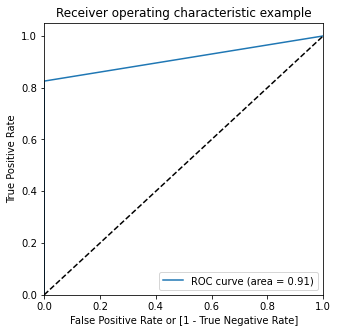


AUC score = 91.28%


Actual 1's =  344 
Predicted 1's =  293

 [[199011      9]
 [    60    284]]

Accuracy = 99.97%
Precision = 96.93%
Recall = 82.56%



          **********  XG BOOST CLASSIFIER(Tuned)_Imbalanced --- TEST SCORES  **********


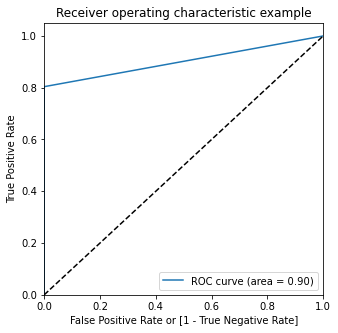


AUC score = 90.20%


Actual 1's =  148 
Predicted 1's =  121

 [[85293     2]
 [   29   119]]

Accuracy = 99.96%
Precision = 98.35%
Recall = 80.41%


In [15]:
dashboard_tuned = pd.DataFrame(columns = ['Model','Sampling Method', 'Train/Test', 'AUC Score', 'Accuracy', 'Precision', 'Recall'])
# with imbalanced train data 
xg_tuned = xg_tuned.fit(X_train, y_train)
y_train_pred = xg_tuned.predict(X_train)
print("\n\n\n          **********  XG BOOST CLASSIFIER(Tuned)_Imbalanced --- TRAIN SCORES  **********")
auc = draw_roc(y_train, y_train_pred)
accuracy, precision, recall = print_Scores(y_train, y_train_pred)
dashboard_tuned = dashboard_tuned.append({'Model' : 'XGBOOST' ,'Sampling Method' : 'None','Train/Test' : 'Train',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True)
    
# with imbalance test data
y_pred = xg_tuned.predict(X_test)
print("\n\n\n          **********  XG BOOST CLASSIFIER(Tuned)_Imbalanced --- TEST SCORES  **********")
auc = draw_roc(y_test, y_pred)
accuracy, precision, recall = print_Scores(y_test, y_pred)
dashboard_tuned = dashboard_tuned.append({'Model' : 'XGBOOST' ,'Sampling Method' : 'None','Train/Test' : 'Test',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True) 

#### Important features in XGBOOST_Tuned_Imbalanced Data

Top var = 17
2nd Top var = 14
3rd Top var = 11


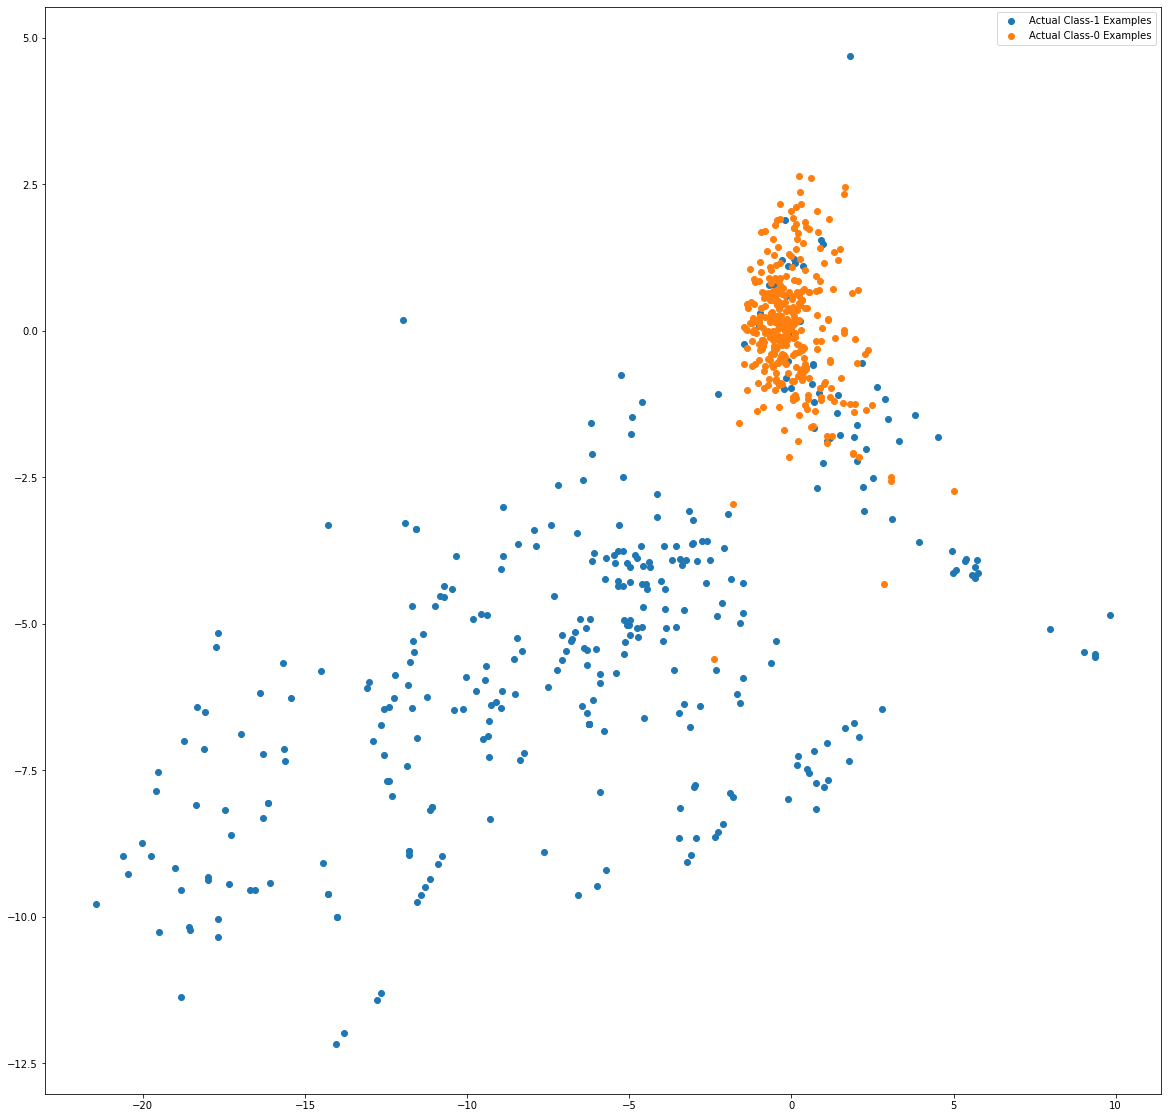

In [16]:
var_imp = []
for i in xg_tuned.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(xg_tuned.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(xg_tuned.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(xg_tuned.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(xg_tuned.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(xg_tuned.feature_importances_)[-2])

X_train_1 = X_train[np.where(y_train==1.0)]
X_train_0 = X_train[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

### Synthetic Minority Over Sampling (SMOTE)

In [17]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)




          **********  Logistic Regression with SMOTE --- TRAIN SCORES  **********


Cross Validation Mean Score:  99.3%


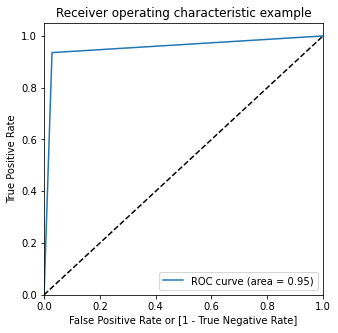


AUC score = 95.36%


Actual 1's =  199020 
Predicted 1's =  191862

 [[193366   5654]
 [ 12812 186208]]

Accuracy = 95.36%
Precision = 97.05%
Recall = 93.56%



          **********  Logistic Regression with SMOTE --- TEST SCORES  **********


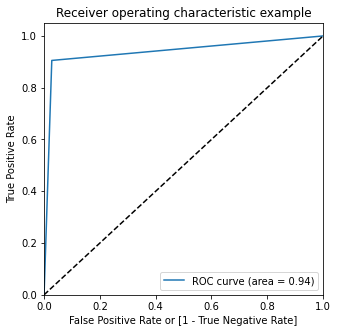


AUC score = 93.89%


Actual 1's =  148 
Predicted 1's =  2492

 [[82937  2358]
 [   14   134]]

Accuracy = 97.22%
Precision = 5.38%
Recall = 90.54%



          **********  K-NN with SMOTE --- TRAIN SCORES  **********


Cross Validation Mean Score:  100.0%


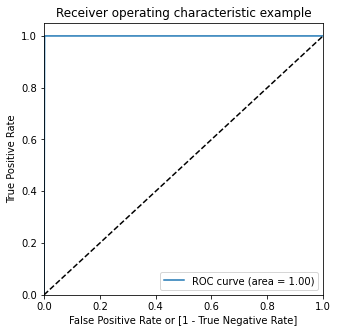


AUC score = 99.90%


Actual 1's =  199020 
Predicted 1's =  199407

 [[198633    387]
 [     0 199020]]

Accuracy = 99.90%
Precision = 99.81%
Recall = 100.00%



          **********  K-NN with SMOTE --- TEST SCORES  **********


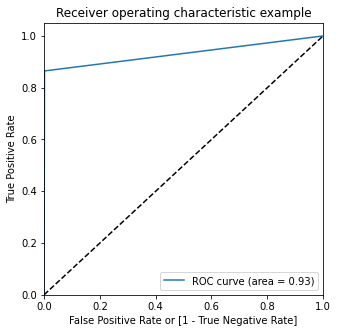


AUC score = 93.16%


Actual 1's =  148 
Predicted 1's =  262

 [[85161   134]
 [   20   128]]

Accuracy = 99.82%
Precision = 48.85%
Recall = 86.49%



          **********  Decision Tree with SMOTE --- TRAIN SCORES  **********


Cross Validation Mean Score:  98.9%


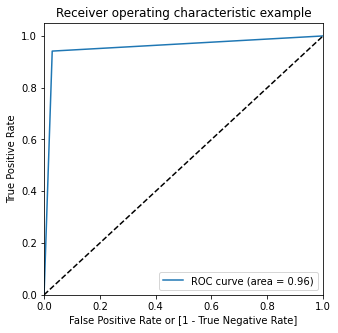


AUC score = 95.61%


Actual 1's =  199020 
Predicted 1's =  193183

 [[193210   5810]
 [ 11647 187373]]

Accuracy = 95.61%
Precision = 96.99%
Recall = 94.15%



          **********  Decision Tree with SMOTE --- TEST SCORES  **********


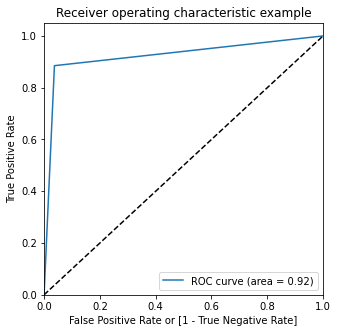


AUC score = 92.40%


Actual 1's =  148 
Predicted 1's =  3298

 [[82128  3167]
 [   17   131]]

Accuracy = 96.27%
Precision = 3.97%
Recall = 88.51%



          **********  Random Forest with SMOTE --- TRAIN SCORES  **********


Cross Validation Mean Score:  99.5%


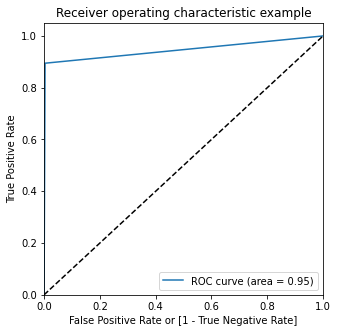


AUC score = 94.56%


Actual 1's =  199020 
Predicted 1's =  178757

 [[198322    698]
 [ 20961 178059]]

Accuracy = 94.56%
Precision = 99.61%
Recall = 89.47%



          **********  Random Forest with SMOTE --- TEST SCORES  **********


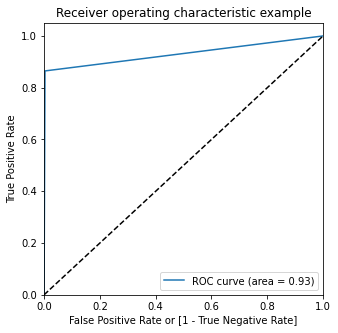


AUC score = 93.08%


Actual 1's =  148 
Predicted 1's =  406

 [[85017   278]
 [   20   128]]

Accuracy = 99.65%
Precision = 31.53%
Recall = 86.49%



          **********  ADA BOOST with SMOTE --- TRAIN SCORES  **********


Cross Validation Mean Score:  99.7%


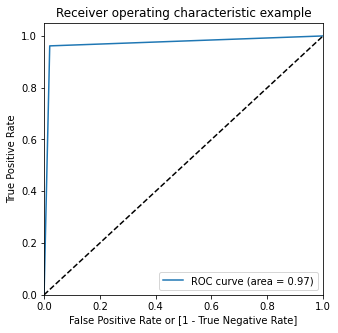


AUC score = 97.07%


Actual 1's =  199020 
Predicted 1's =  195412

 [[194988   4032]
 [  7640 191380]]

Accuracy = 97.07%
Precision = 97.94%
Recall = 96.16%



          **********  ADA BOOST with SMOTE --- TEST SCORES  **********


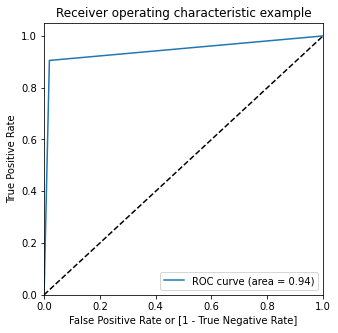


AUC score = 94.32%


Actual 1's =  148 
Predicted 1's =  1759

 [[83670  1625]
 [   14   134]]

Accuracy = 98.08%
Precision = 7.62%
Recall = 90.54%



          **********  Gradient BOOST with SMOTE --- TRAIN SCORES  **********


Cross Validation Mean Score:  99.9%


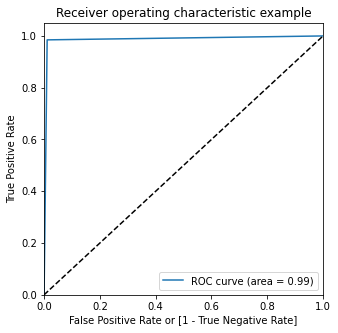


AUC score = 98.69%


Actual 1's =  199020 
Predicted 1's =  198205

 [[196823   2197]
 [  3012 196008]]

Accuracy = 98.69%
Precision = 98.89%
Recall = 98.49%



          **********  Gradient BOOST with SMOTE --- TEST SCORES  **********


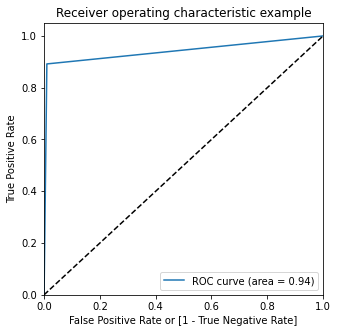


AUC score = 94.10%


Actual 1's =  148 
Predicted 1's =  983

 [[84444   851]
 [   16   132]]

Accuracy = 98.99%
Precision = 13.43%
Recall = 89.19%



          **********  XG BOOST with SMOTE --- TRAIN SCORES  **********


Cross Validation Mean Score:  99.9%


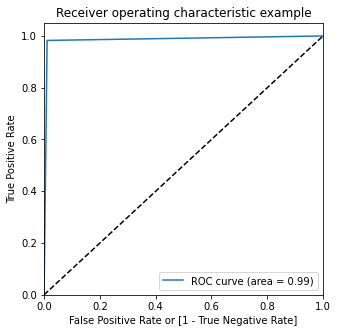


AUC score = 98.59%


Actual 1's =  199020 
Predicted 1's =  197725

 [[196857   2163]
 [  3458 195562]]

Accuracy = 98.59%
Precision = 98.91%
Recall = 98.26%



          **********  XG BOOST with SMOTE --- TEST SCORES  **********


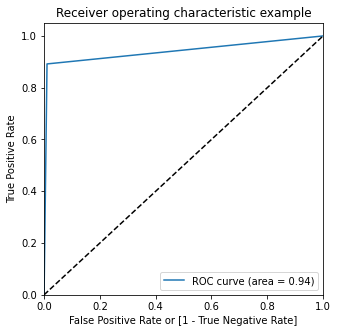


AUC score = 94.07%


Actual 1's =  148 
Predicted 1's =  1033

 [[84394   901]
 [   16   132]]

Accuracy = 98.93%
Precision = 12.78%
Recall = 89.19%


In [32]:
dashboard_SMOTE = pd.DataFrame(columns = ['Model','Sampling Method', 'Train/Test', 'AUC Score', 'Accuracy', 'Precision', 'Recall'])
for model in models.keys():
    # with SMOTE train
    m = models[model].fit(X_smote, y_smote)
    y_smote_pred = cross_val_predict(m, X_smote, y_smote, cv=5)
    scores = cross_val_score(m, X_smote, y_smote, scoring='roc_auc', cv=5)
    print("\n\n\n          **********  {} with SMOTE --- TRAIN SCORES  **********".format(model))
    print ("\n\nCross Validation Mean Score: ", '{}%'.format(np.round(scores.mean(), 3) * 100))
    auc = draw_roc(y_smote, y_smote_pred)
    accuracy, precision, recall = print_Scores(y_smote, y_smote_pred)
    dashboard_SMOTE = dashboard_SMOTE.append({'Model' : model ,'Sampling Method' : 'SMOTE','Train/Test' : 'Train',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True)
    # with SMOTE test
    y_smote_test_pred = m.predict(X_test)
    print("\n\n\n          **********  {} with SMOTE --- TEST SCORES  **********".format(model))
    auc = draw_roc(y_test, y_smote_test_pred)
    accuracy, precision, recall = print_Scores(y_test, y_smote_test_pred)
    dashboard_SMOTE = dashboard_SMOTE.append({'Model' : model ,'Sampling Method' : 'SMOTE','Train/Test' : 'Test',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True)

In [33]:
dashboard_SMOTE

,Model,Sampling Method,Train/Test,AUC Score,Accuracy,Precision,Recall
0,Logistic Regression,SMOTE,Train,0.953608,0.953608,0.970531,0.935625
1,Logistic Regression,SMOTE,Test,0.938880,0.972239,0.053772,0.905405
2,K-NN,SMOTE,Train,0.999028,0.999028,0.998059,1.000000
3,K-NN,SMOTE,Test,0.931647,0.998198,0.488550,0.864865
4,Decision Tree,SMOTE,Train,0.956143,0.956143,0.969925,0.941478
5,Decision Tree,SMOTE,Test,0.924003,0.962735,0.039721,0.885135
6,Random Forest,SMOTE,Train,0.945586,0.945586,0.996095,0.894679
7,Random Forest,SMOTE,Test,0.930803,0.996512,0.315271,0.864865
8,ADA BOOST,SMOTE,Train,0.970676,0.970676,0.979367,0.961612
9,ADA BOOST,SMOTE,Test,0.943177,0.980818,0.076180,0.905405


In [34]:
# Sorting Models according to their AUC, Recall score.
dashboard_SMOTE = dashboard_SMOTE.sort_values(['AUC Score','Recall'], ascending=[False, False])
dashboard_SMOTE

,Model,Sampling Method,Train/Test,AUC Score,Accuracy,Precision,Recall
2,K-NN,SMOTE,Train,0.999028,0.999028,0.998059,1.000000
10,Gradient BOOST,SMOTE,Train,0.986913,0.986913,0.988916,0.984866
12,XG BOOST,SMOTE,Train,0.985878,0.985878,0.989061,0.982625
8,ADA BOOST,SMOTE,Train,0.970676,0.970676,0.979367,0.961612
4,Decision Tree,SMOTE,Train,0.956143,0.956143,0.969925,0.941478
0,Logistic Regression,SMOTE,Train,0.953608,0.953608,0.970531,0.935625
6,Random Forest,SMOTE,Train,0.945586,0.945586,0.996095,0.894679
9,ADA BOOST,SMOTE,Test,0.943177,0.980818,0.076180,0.905405
11,Gradient BOOST,SMOTE,Test,0.940957,0.989853,0.134283,0.891892
13,XG BOOST,SMOTE,Test,0.940664,0.989268,0.127783,0.891892


Here we can see that ADABOOST gives the best AUC on Test data and a recall greater then 0.9. SO we will tune this model further
## Hyper parameter tuning : SMOTE Oversampling - ADABOOST Classifier

### 1. Tuning learning_rate

In [27]:
n_folds = 5       # No of folds for gridsearch CV
# parameters to build the model on
parameters = {"learning_rate" : [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2]}
# instantiate the model
ada = AdaBoostClassifier(random_state = 42)
# fit tree on training data
adab = GridSearchCV(ada, parameters, 
                    cv = n_folds,
                    n_jobs = -1,
                    return_train_score = True,
                    scoring="roc_auc")
adab.fit(X_smote, y_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15,
                                           0.2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

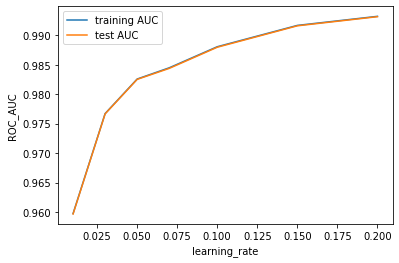

In [28]:
scores = adab.cv_results_

plt.figure()
plt.plot(scores["param_learning_rate"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_learning_rate"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("learning_rate")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

Here we can see that test AUC increases till learning rate = 0.15 to 0.2
### 2. Tuning n_estimators

In [29]:
# parameters to build the model on
parameters = {"n_estimators"    : range(50,200,50) }
# fit tree on training data
adab = GridSearchCV(ada, parameters, 
                    cv = n_folds,
                    n_jobs = -1,
                    return_train_score = True,
                    scoring="roc_auc")
adab.fit(X_smote, y_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': range(50, 200, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

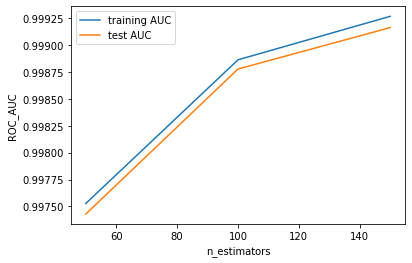

In [30]:
scores = adab.cv_results_
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("n_estimators")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

Here we can see that taking more no. of estimators decreases AUC so, we will take it between 100,300
### Grid Search to Find Optimal Hyperparameters

In [31]:
# Create the parameter grid 
param_grid = {"learning_rate" : [0.125,0.15,0.175,0.2,0.25],
              "n_estimators": range(100,300,50)
             }

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ada, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, scoring ='roc_auc',verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_smote,y_smote)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 53.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.125, 0.15, 0.175, 0.2, 0.25],
                         'n_estimators': range(100, 300, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [32]:
# printing the optimal accuracy score and hyperparameters
print("Best AUC : ", grid_search.best_score_)
print('Best Parameteres : ', grid_search.best_params_)

Best AUC :  0.9983766776544836
Best Parameteres :  {'learning_rate': 0.25, 'n_estimators': 250}


In [18]:
# model with optimal hyperparameters
ada_tuned = AdaBoostClassifier(learning_rate = 0.25, n_estimators = 250, random_state = 42)




          **********  ADBOOST(Tuned)_SMOTE --- TRAIN SCORES  **********


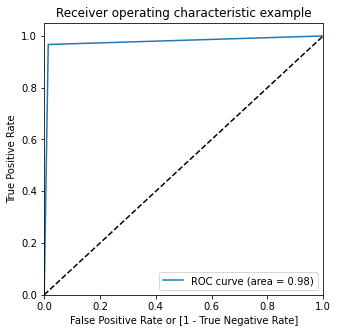


AUC score = 97.63%


Actual 1's =  199020 
Predicted 1's =  195326

 [[196141   2879]
 [  6573 192447]]

Accuracy = 97.63%
Precision = 98.53%
Recall = 96.70%



          **********  ADABOOST(Tuned)_SMOTE --- TEST SCORES  **********


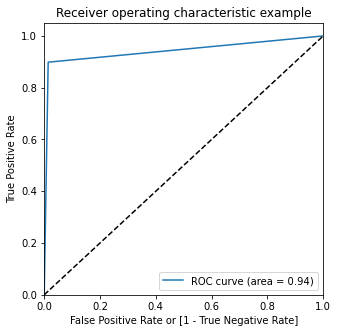


AUC score = 94.22%


Actual 1's =  148 
Predicted 1's =  1348

 [[84080  1215]
 [   15   133]]

Accuracy = 98.56%
Precision = 9.87%
Recall = 89.86%


In [19]:
#dashboard_tuned = pd.DataFrame(columns = ['Model','Sampling Method', 'Train/Test', 'AUC Score', 'Accuracy', 'Precision', 'Recall'])
# with SMOTE train data 
ada_tuned = ada_tuned.fit(X_smote, y_smote)
y_smote_pred = ada_tuned.predict(X_smote)
print("\n\n\n          **********  ADBOOST(Tuned)_SMOTE --- TRAIN SCORES  **********")
auc = draw_roc(y_smote, y_smote_pred)
accuracy, precision, recall = print_Scores(y_smote, y_smote_pred)
dashboard_tuned = dashboard_tuned.append({'Model' : 'ADABOOST' ,'Sampling Method' : 'SMOTE','Train/Test' : 'Train',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True)
    
# with SMOTE test data
y_pred = ada_tuned.predict(X_test)
print("\n\n\n          **********  ADABOOST(Tuned)_SMOTE --- TEST SCORES  **********")
auc = draw_roc(y_test, y_pred)
accuracy, precision, recall = print_Scores(y_test, y_pred)
dashboard_tuned = dashboard_tuned.append({'Model' : 'ADABOOST' ,'Sampling Method' : 'SMOTE','Train/Test' : 'Test',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True) 

#### Important features in ADABOOST_Tuned_SMOTE

Top var = 14
2nd Top var = 18
3rd Top var = 4


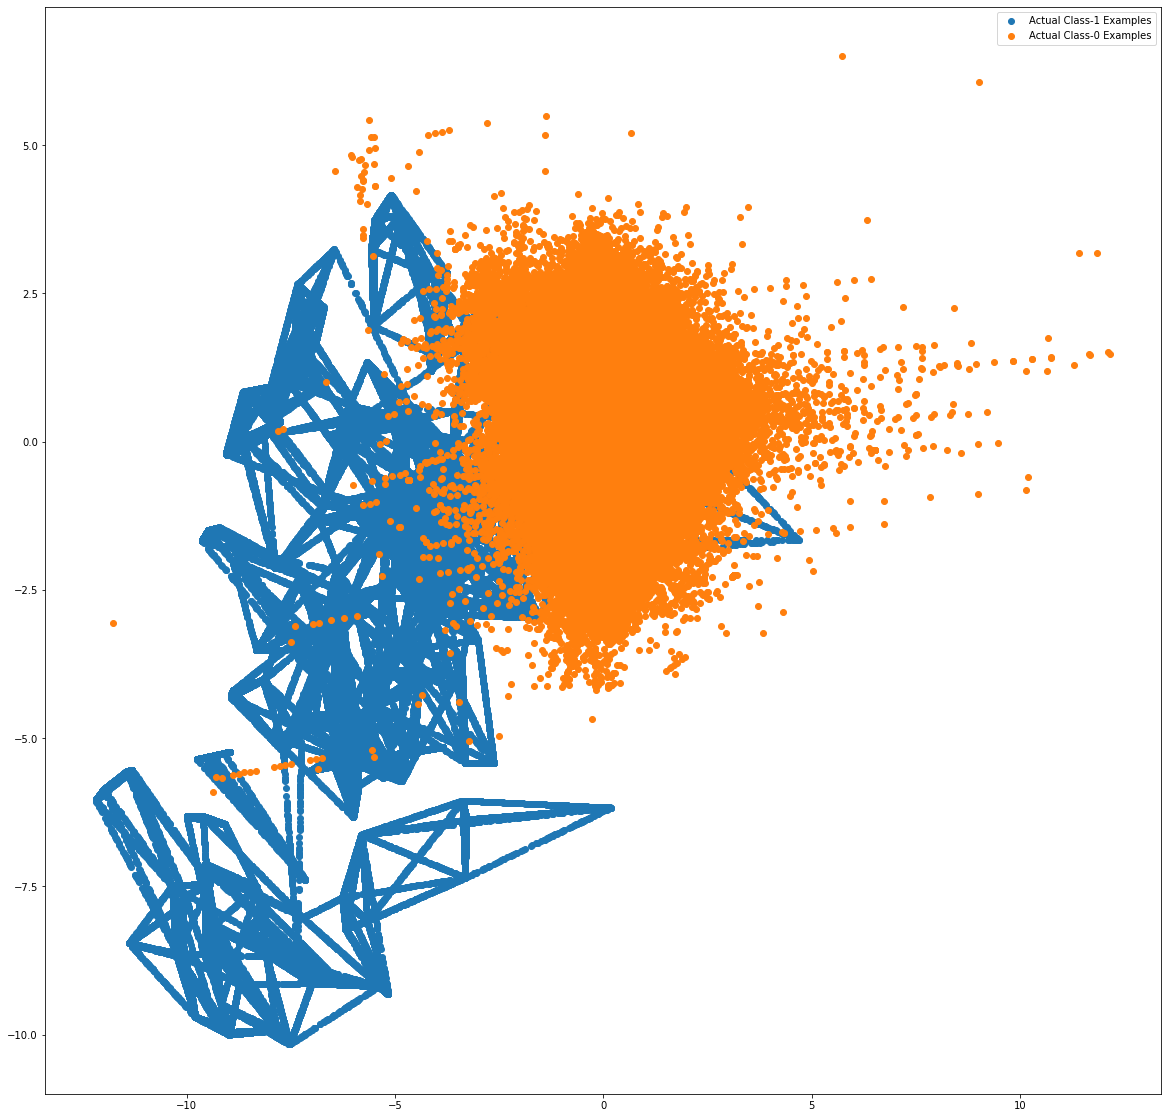

In [20]:
var_imp = []
for i in ada_tuned.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(ada_tuned.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(ada_tuned.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(ada_tuned.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(ada_tuned.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(ada_tuned.feature_importances_)[-2])

X_train_1 = X_smote[np.where(y_smote==1.0)]
X_train_0 = X_smote[np.where(y_smote==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

### Adaptive Synthetic Minority Over Sampling (ADASYN)

In [21]:
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)




          **********  Logistic Regression with ADASYN --- TRAIN SCORES  **********


Cross Validation Mean Score:  96.39999999999999%


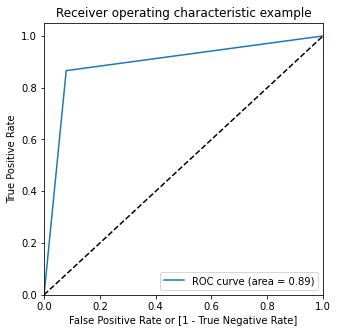


AUC score = 89.33%


Actual 1's =  199004 
Predicted 1's =  188131

 [[183229  15791]
 [ 26664 172340]]

Accuracy = 89.33%
Precision = 91.61%
Recall = 86.60%



          **********  Logistic Regression with ADASYN --- TEST SCORES  **********


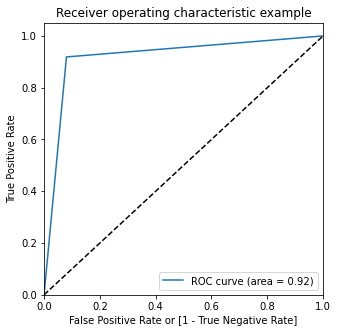


AUC score = 91.94%


Actual 1's =  148 
Predicted 1's =  6977

 [[78454  6841]
 [   12   136]]

Accuracy = 91.98%
Precision = 1.95%
Recall = 91.89%



          **********  K-NN with ADASYN --- TRAIN SCORES  **********


Cross Validation Mean Score:  98.8%


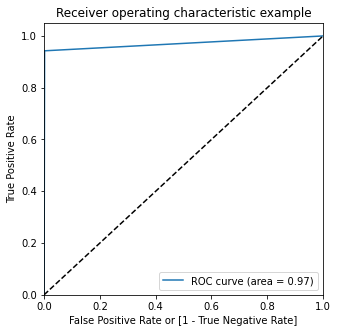


AUC score = 97.04%


Actual 1's =  199004 
Predicted 1's =  187948

 [[198652    368]
 [ 11424 187580]]

Accuracy = 97.04%
Precision = 99.80%
Recall = 94.26%



          **********  K-NN with ADASYN --- TEST SCORES  **********


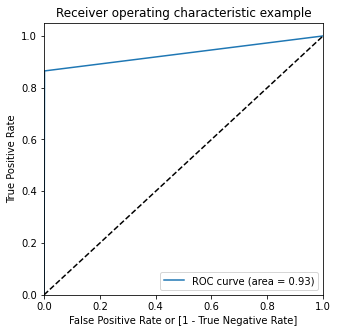


AUC score = 93.16%


Actual 1's =  148 
Predicted 1's =  263

 [[85160   135]
 [   20   128]]

Accuracy = 99.82%
Precision = 48.67%
Recall = 86.49%



          **********  Decision Tree with ADASYN --- TRAIN SCORES  **********


Cross Validation Mean Score:  94.5%


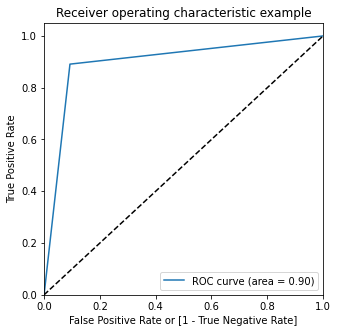


AUC score = 89.92%


Actual 1's =  199004 
Predicted 1's =  195799

 [[180558  18462]
 [ 21667 177337]]

Accuracy = 89.92%
Precision = 90.57%
Recall = 89.11%



          **********  Decision Tree with ADASYN --- TEST SCORES  **********


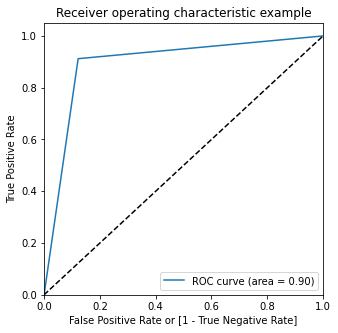


AUC score = 89.50%


Actual 1's =  148 
Predicted 1's =  10549

 [[74881 10414]
 [   13   135]]

Accuracy = 87.80%
Precision = 1.28%
Recall = 91.22%



          **********  Random Forest with ADASYN --- TRAIN SCORES  **********


Cross Validation Mean Score:  98.0%


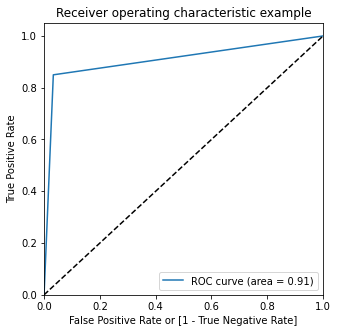


AUC score = 90.83%


Actual 1's =  199004 
Predicted 1's =  175718

 [[192419   6601]
 [ 29887 169117]]

Accuracy = 90.83%
Precision = 96.24%
Recall = 84.98%



          **********  Random Forest with ADASYN --- TEST SCORES  **********


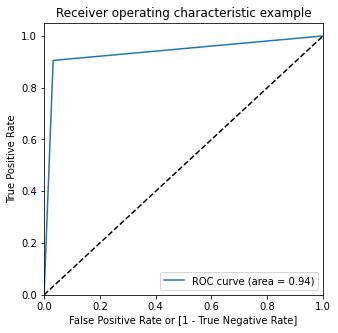


AUC score = 93.64%


Actual 1's =  148 
Predicted 1's =  2907

 [[82522  2773]
 [   14   134]]

Accuracy = 96.74%
Precision = 4.61%
Recall = 90.54%



          **********  ADA BOOST with ADASYN --- TRAIN SCORES  **********


Cross Validation Mean Score:  97.89999999999999%


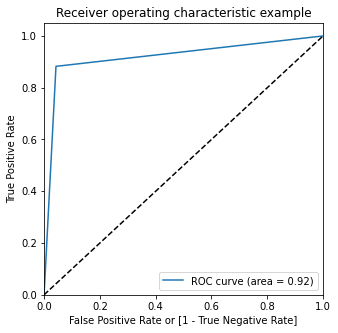


AUC score = 91.99%


Actual 1's =  199004 
Predicted 1's =  184119

 [[190530   8490]
 [ 23375 175629]]

Accuracy = 91.99%
Precision = 95.39%
Recall = 88.25%



          **********  ADA BOOST with ADASYN --- TEST SCORES  **********


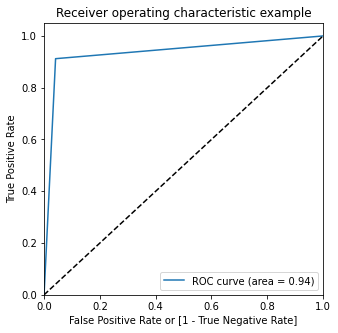


AUC score = 93.55%


Actual 1's =  148 
Predicted 1's =  3652

 [[81778  3517]
 [   13   135]]

Accuracy = 95.87%
Precision = 3.70%
Recall = 91.22%



          **********  Gradient BOOST with ADASYN --- TRAIN SCORES  **********


Cross Validation Mean Score:  99.1%


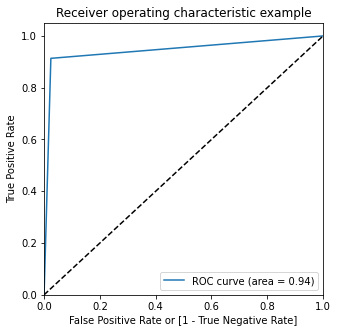


AUC score = 94.46%


Actual 1's =  199004 
Predicted 1's =  186628

 [[194176   4844]
 [ 17220 181784]]

Accuracy = 94.46%
Precision = 97.40%
Recall = 91.35%



          **********  Gradient BOOST with ADASYN --- TEST SCORES  **********


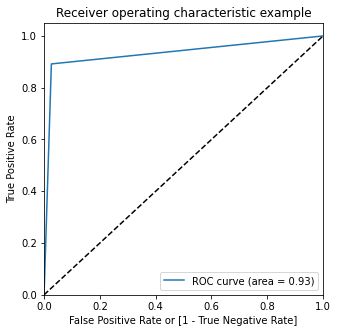


AUC score = 93.29%


Actual 1's =  148 
Predicted 1's =  2364

 [[83063  2232]
 [   16   132]]

Accuracy = 97.37%
Precision = 5.58%
Recall = 89.19%



          **********  XG BOOST with ADASYN --- TRAIN SCORES  **********


Cross Validation Mean Score:  99.2%


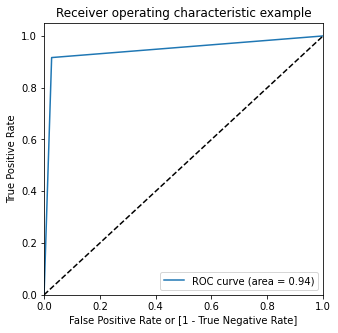


AUC score = 94.47%


Actual 1's =  199004 
Predicted 1's =  187775

 [[193628   5392]
 [ 16621 182383]]

Accuracy = 94.47%
Precision = 97.13%
Recall = 91.65%



          **********  XG BOOST with ADASYN --- TEST SCORES  **********


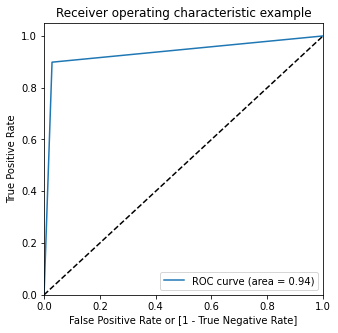


AUC score = 93.51%


Actual 1's =  148 
Predicted 1's =  2567

 [[82861  2434]
 [   15   133]]

Accuracy = 97.13%
Precision = 5.18%
Recall = 89.86%


In [36]:
dashboard_ADASYN = pd.DataFrame(columns = ['Model','Sampling Method', 'Train/Test', 'AUC Score', 'Accuracy', 'Precision', 'Recall'])
for model in models.keys(): 
    # with ADASYN train
    m = models[model].fit(X_adasyn, y_adasyn)
    y_adasyn_pred = cross_val_predict(m, X_adasyn, y_adasyn, cv=5)
    scores = cross_val_score(m, X_adasyn, y_adasyn, scoring='roc_auc', cv=5)
    print("\n\n\n          **********  {} with ADASYN --- TRAIN SCORES  **********".format(model))
    print ("\n\nCross Validation Mean Score: ", '{}%'.format(np.round(scores.mean(), 3) * 100))
    auc = draw_roc(y_adasyn, y_adasyn_pred)
    accuracy, precision, recall = print_Scores(y_adasyn, y_adasyn_pred)
    dashboard_ADASYN = dashboard_ADASYN.append({'Model' : model ,'Sampling Method' : 'ADASYN','Train/Test' : 'Train',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True)
    # with ADASYN test
    y_adasyn_test_pred = m.predict(X_test)
    print("\n\n\n          **********  {} with ADASYN --- TEST SCORES  **********".format(model))
    auc = draw_roc(y_test, y_adasyn_test_pred)
    accuracy, precision, recall = print_Scores(y_test, y_adasyn_test_pred)
    dashboard_ADASYN = dashboard_ADASYN.append({'Model' : model ,'Sampling Method' : 'ADASYN','Train/Test' : 'Test',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True)

In [37]:
dashboard_ADASYN

,Model,Sampling Method,Train/Test,AUC Score,Accuracy,Precision,Recall
0,Logistic Regression,ADASYN,Train,0.893334,0.893336,0.916064,0.866013
1,Logistic Regression,ADASYN,Test,0.919357,0.919794,0.019493,0.918919
2,K-NN,ADASYN,Train,0.970373,0.970374,0.998042,0.942594
3,K-NN,ADASYN,Test,0.931641,0.998186,0.486692,0.864865
4,Decision Tree,ADASYN,Train,0.899179,0.899179,0.905709,0.891123
5,Decision Tree,ADASYN,Test,0.895034,0.877965,0.012797,0.912162
6,Random Forest,ADASYN,Train,0.908325,0.908327,0.962434,0.849817
7,Random Forest,ADASYN,Test,0.936447,0.967382,0.046096,0.905405
8,ADA BOOST,ADASYN,Train,0.919941,0.919942,0.953889,0.882540
9,ADA BOOST,ADASYN,Test,0.935464,0.958686,0.036966,0.912162


In [39]:
dashboard_ADASYN = dashboard_ADASYN.sort_values(['AUC Score','Recall'], ascending=[False, False])
dashboard_ADASYN

,Model,Sampling Method,Train/Test,AUC Score,Accuracy,Precision,Recall
2,K-NN,ADASYN,Train,0.970373,0.970374,0.998042,0.942594
12,XG BOOST,ADASYN,Train,0.944693,0.944694,0.971285,0.916479
10,Gradient BOOST,ADASYN,Train,0.944565,0.944566,0.974045,0.913469
7,Random Forest,ADASYN,Test,0.936447,0.967382,0.046096,0.905405
9,ADA BOOST,ADASYN,Test,0.935464,0.958686,0.036966,0.912162
13,XG BOOST,ADASYN,Test,0.935056,0.971338,0.051811,0.898649
11,Gradient BOOST,ADASYN,Test,0.932862,0.973690,0.055838,0.891892
3,K-NN,ADASYN,Test,0.931641,0.998186,0.486692,0.864865
8,ADA BOOST,ADASYN,Train,0.919941,0.919942,0.953889,0.882540
1,Logistic Regression,ADASYN,Test,0.919357,0.919794,0.019493,0.918919


Here we can see that Random Forest gives best AUC with a good recall on test data. So we must tune it further.
## Hyper parameter tuning : ADASYN Oversampling - Random Forest Classifier

### 1. Tuning max_depth

In [29]:
# specify number of folds for k-fold CV
n_folds = 5
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}
# instantiate the model
rf = RandomForestClassifier(random_state = 42)

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                  return_train_score=True,
                   scoring="roc_auc", n_jobs=-1)
rf.fit(X_adasyn, y_adasyn)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

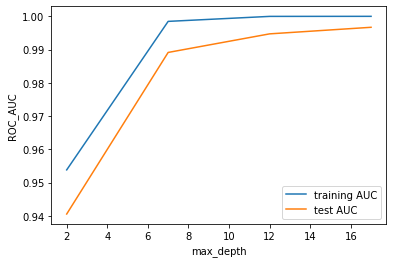

In [31]:
scores = rf.cv_results_
# plotting AUC with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("max_depth")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

This shows that ideal max depth must be 7 to 14
### 2. Tuning n_estimators

In [33]:
parameters = {'n_estimators': range(50, 300, 50)}
rf = RandomForestClassifier(max_depth=4, random_state = 42)
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, 
                  return_train_score=True, scoring="roc_auc", n_jobs=-1)
rf.fit(X_adasyn, y_adasyn)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                     

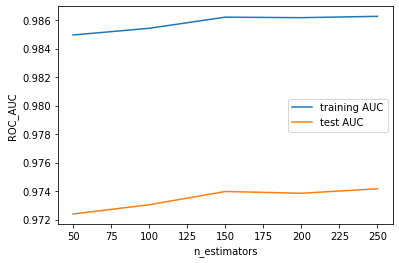

In [34]:
scores = rf.cv_results_
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("n_estimators")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

This shows that n_estimators must be kept around 150
### 3. Tuning max_features

In [39]:
parameters = {'max_features': range(6,30,6)}
# fit tree on training data
rf = GridSearchCV(RandomForestClassifier(max_depth=4, random_state = 42), parameters, cv=n_folds, 
                  return_train_score=True, scoring="roc_auc", n_jobs=-1)
rf.fit(X_adasyn, y_adasyn)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                     

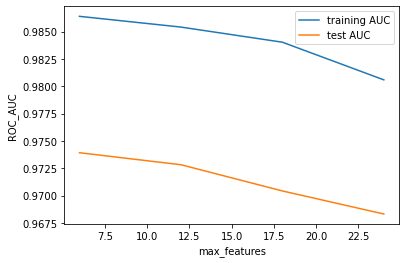

In [40]:
scores = rf.cv_results_
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("max_features")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

This shos that max_features must be low. i.e. around 5,6
### 4. Tuning min_sample_leaf

In [37]:
parameters = {'min_samples_leaf': range(20, 200, 40)}
rf = RandomForestClassifier(random_state = 42)
# fit tree on training data
rf = GridSearchCV(rf, parameters, cv=n_folds, 
                  return_train_score=True, scoring="roc_auc", n_jobs=-1)
rf.fit(X_adasyn, y_adasyn)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

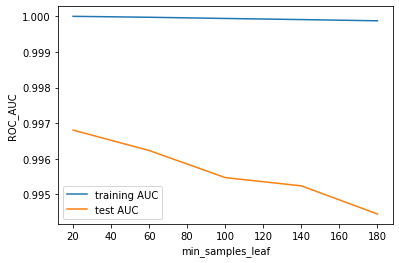

In [38]:
scores = rf.cv_results_
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training AUC")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test AUC")
plt.xlabel("min_samples_leaf")
plt.ylabel("ROC_AUC")
plt.legend()
plt.show()

here we can see that accuracy decreases as increase min_sample_leaf. So we keep it in the range around 10 to 30.

## Grid Search to Find Optimal Hyperparameters

In [22]:
# Create the parameter grid based on the results of random search 
param_grid = {'max_depth': [7,9,11],
              'min_samples_leaf': [10,20,30],
              'n_estimators': [130,150,170], 
              'max_features': [5,6,7]
              }
# Create a based model
rf = RandomForestClassifier(random_state = 42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)
# Fit the grid search to the data
grid_search.fit(X_adasyn,y_adasyn)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 118.7min
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 166.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [23]:
# printing the optimal accuracy score and hyperparameters
print("Best AUC = ", grid_search.best_score_)
print('Best Parameteres = ', grid_search.best_params_)

Best AUC =  0.9380313768411628
Best Parameteres =  {'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 20, 'n_estimators': 170}


In [25]:
# model with optimal hyperparameters
rf_tuned = RandomForestClassifier(max_depth = 9,
                                  max_features = 7,
                                  min_samples_leaf = 20,
                                  n_estimators = 170,
                                  random_state = 42)




          **********  Random Forest(Tuned)_ADASYN --- TRAIN SCORES  **********


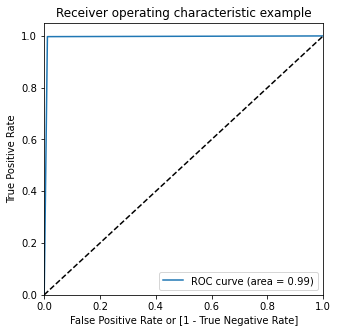


AUC score = 99.29%


Actual 1's =  199004 
Predicted 1's =  200766

 [[196729   2291]
 [   529 198475]]

Accuracy = 99.29%
Precision = 98.86%
Recall = 99.73%



          **********  Random Forest(Tuned)_ADASYN --- TEST SCORES  **********


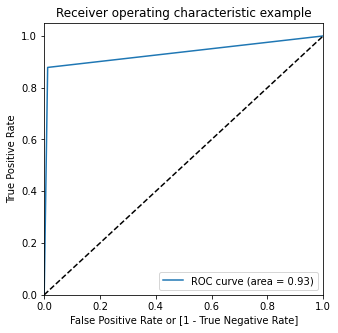


AUC score = 93.30%


Actual 1's =  148 
Predicted 1's =  1187

 [[84238  1057]
 [   18   130]]

Accuracy = 98.74%
Precision = 10.95%
Recall = 87.84%


In [26]:
# Fitting and analysing optimal model with ADASYN train data 
rf_tuned = rf_tuned.fit(X_adasyn, y_adasyn)
y_adasyn_pred = rf_tuned.predict(X_adasyn)
print("\n\n\n          **********  Random Forest(Tuned)_ADASYN --- TRAIN SCORES  **********")
auc = draw_roc(y_adasyn, y_adasyn_pred)
accuracy, precision, recall = print_Scores(y_adasyn, y_adasyn_pred)
dashboard_tuned = dashboard_tuned.append({'Model' : 'Random Forest' ,'Sampling Method' : 'ADASYN','Train/Test' : 'Train',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True)
    
# with ADASYN test data
y_pred = rf_tuned.predict(X_test)
print("\n\n\n          **********  Random Forest(Tuned)_ADASYN --- TEST SCORES  **********")
auc = draw_roc(y_test, y_pred)
accuracy, precision, recall = print_Scores(y_test, y_pred)
dashboard_tuned = dashboard_tuned.append({'Model' : 'Random Forest' ,'Sampling Method' : 'ADASYN','Train/Test' : 'Test',
                                  'AUC Score' : auc,'Accuracy' : accuracy,'Precision' : precision,'Recall' : recall},
                                  ignore_index = True) 

### Important Features: Random Forest_Tuned_ADASYN

Top var = 4
2nd Top var = 14
3rd Top var = 12


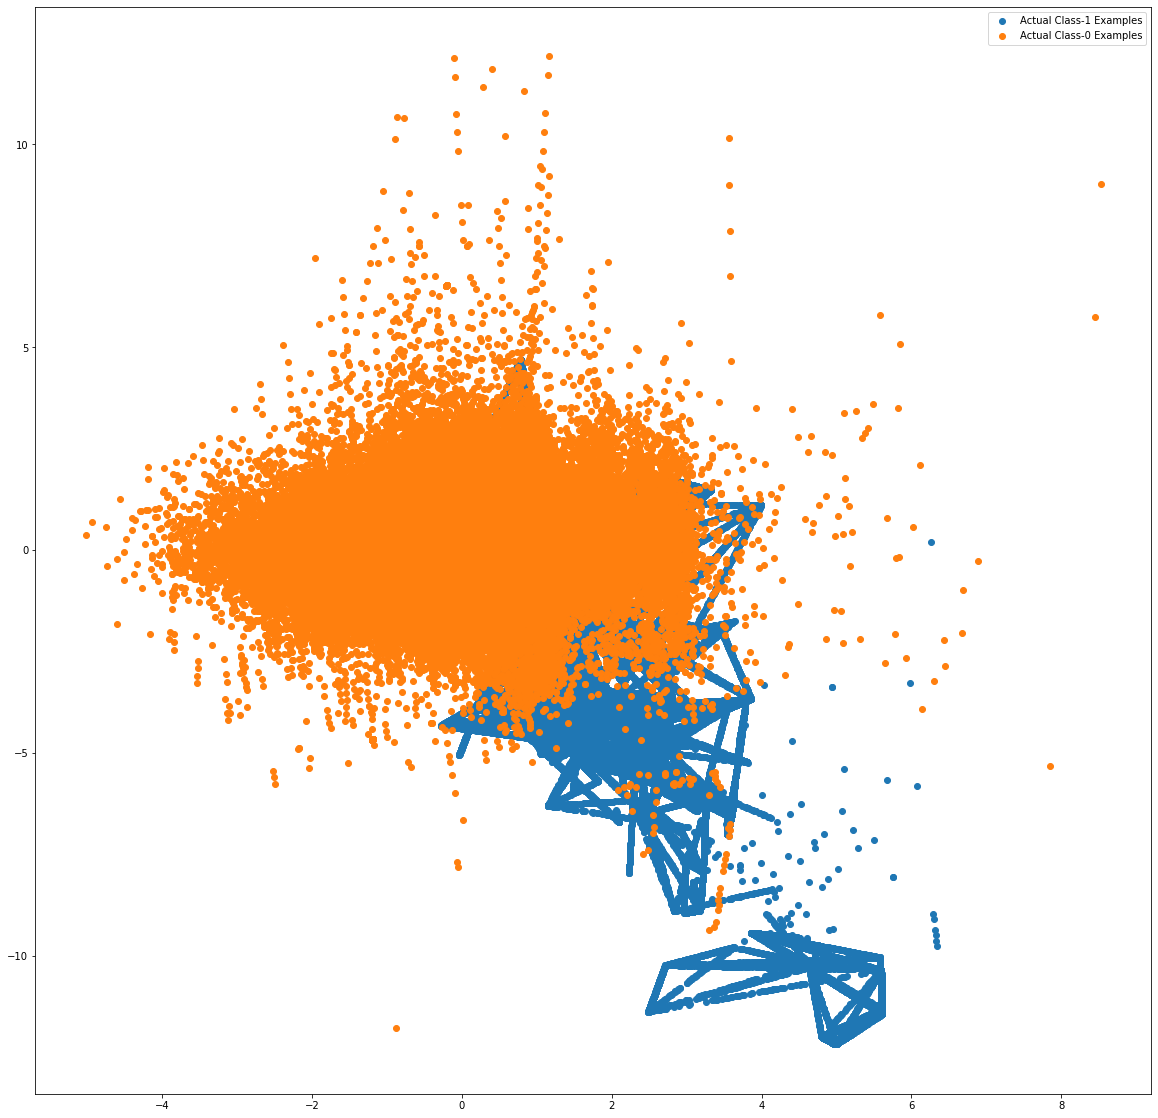

In [27]:
var_imp = []
for i in rf_tuned.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(rf_tuned.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(rf_tuned.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(rf_tuned.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(rf_tuned.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(rf_tuned.feature_importances_)[-2])

X_train_1 = X_adasyn[np.where(y_adasyn==1.0)]
X_train_0 = X_adasyn[np.where(y_adasyn==0.0)]

np.random.shuffle(X_train_0)
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

#### We have tuned the best performing model for each type of smapling methods and did hyperparameter tuning. 
Due to limited availability of resources and running time complexity of the whole program, we decided not to tune all the models. We tried on google colab and google cloud also but it is taking more than 20 hours to run the complete notebook on google cloud and it crashes on our local machines, even colab is not worth.

## Following is a list of all the tuned models with their final AUC, Recall and Precision

In [28]:
dashboard_tuned

,Model,Sampling Method,Train/Test,AUC Score,Accuracy,Precision,Recall
0,XGBOOST,None,Train,0.912768,0.999654,0.969283,0.825581
1,XGBOOST,None,Test,0.902015,0.999637,0.983471,0.804054
2,ADABOOST,SMOTE,Train,0.976254,0.976254,0.985261,0.966973
3,ADABOOST,SMOTE,Test,0.942202,0.985604,0.098665,0.898649
4,Random Forest,ADASYN,Train,0.992915,0.992915,0.988589,0.997342
5,Random Forest,ADASYN,Test,0.932993,0.987419,0.109520,0.878378


In [30]:
# Sorting the list of models in order of Descending AUC, Recall and precision in the same priority as written
dashboard_tuned.sort_values(['AUC Score','Recall','Precision'], ascending = [False, False, False])

,Model,Sampling Method,Train/Test,AUC Score,Accuracy,Precision,Recall
4,Random Forest,ADASYN,Train,0.992915,0.992915,0.988589,0.997342
2,ADABOOST,SMOTE,Train,0.976254,0.976254,0.985261,0.966973
3,ADABOOST,SMOTE,Test,0.942202,0.985604,0.098665,0.898649
5,Random Forest,ADASYN,Test,0.932993,0.987419,0.109520,0.878378
0,XGBOOST,None,Train,0.912768,0.999654,0.969283,0.825581
1,XGBOOST,None,Test,0.902015,0.999637,0.983471,0.804054


Here we can see that the best performing model on Test Data is:
## ADABOOST on SMOTE Oversampling
#### because it has highest AUC of 0.94 and recall of 0.89 on test dataset.
Though XGBOOST on imbalanced data is best performer and gives a very high accuracy and precision( ~ 99%) but it has a weaker recall value. So we cannot choose it.
Here we have prioritized recall over precision and accuracy because we don't want any Actual fraud to be detected as non-fraud and this is possible in High RECALL models

In [31]:
final_model = ada_tuned

In [45]:
final_model.feature_importances_

array([0.024, 0.04 , 0.028, 0.072, 0.012, 0.028, 0.032, 0.056, 0.036,
       0.044, 0.036, 0.056, 0.016, 0.088, 0.012, 0.02 , 0.044, 0.076,
       0.028, 0.024, 0.016, 0.024, 0.024, 0.024, 0.044, 0.024, 0.028,
       0.016, 0.028])

In [48]:
coef = pd.Series(final_model.feature_importances_, index = X.columns)
coef

V1        0.024
V2        0.040
V3        0.028
V4        0.072
V5        0.012
V6        0.028
V7        0.032
V8        0.056
V9        0.036
V10       0.044
V11       0.036
V12       0.056
V13       0.016
V14       0.088
V15       0.012
V16       0.020
V17       0.044
V18       0.076
V19       0.028
V20       0.024
V21       0.016
V22       0.024
V23       0.024
V24       0.024
V25       0.044
V26       0.024
V27       0.028
V28       0.016
Amount    0.028
dtype: float64

Text(0.5, 1.0, 'Most and Least important variables')

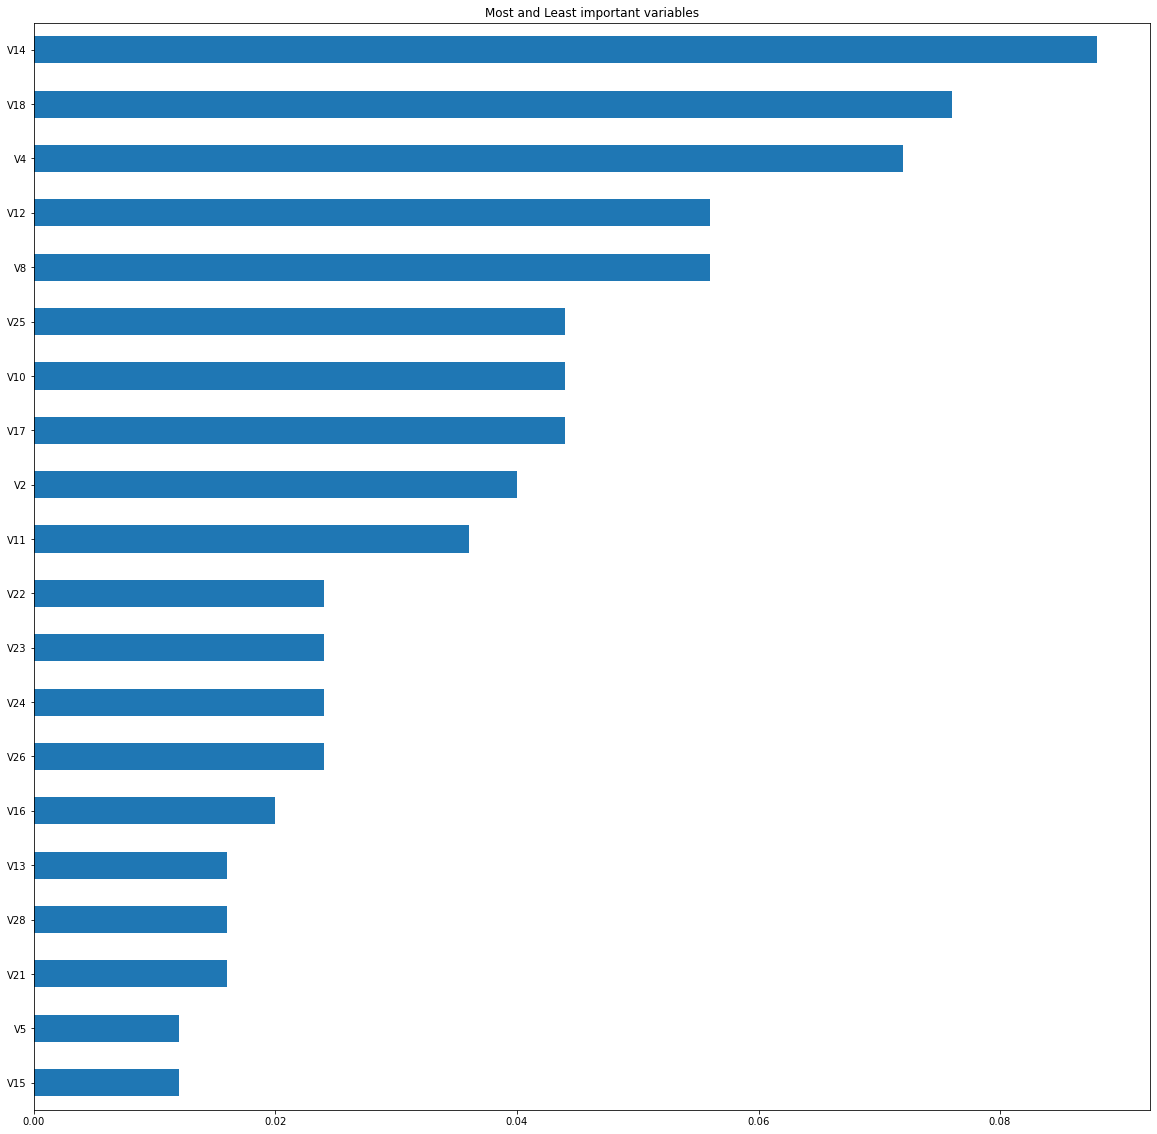

In [51]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
figsize=(20,50)
imp_coef.plot(kind = "barh")
plt.title("Most and Least important variables")